# 멀티 에이전트 협업 네트워크

이 튜토리얼에서는 **멀티 에이전트 네트워크**를 LangGraph를 활용하여 구현하는 방법을 다룹니다.  
멀티 에이전트 네트워크는 복잡한 작업을 여러 개의 전문화된 에이전트들로 나누어 처리하는 "분할 정복" 접근 방식을 사용하는 아키텍처입니다. 

이를 통해 단일 에이전트가 많은 도구를 비효율적으로 사용하는 문제를 해결하고, 각 에이전트가 자신의 전문 분야에서 효과적으로 문제를 해결하도록 합니다.

본 튜토리얼은 [AutoGen 논문](https://arxiv.org/abs/2308.08155)에서 영감을 받아, LangGraph를 활용하여 이러한 멀티 에이전트 네트워크를 구축하는 방법을 단계별로 살펴봅니다. 또한, LangSmith를 사용하여 프로젝트 성능을 개선하고 문제를 빠르게 식별하는 방법도 소개합니다.

![](./assets/langgraph-multi-agent.png)

---

**왜 멀티 에이전트 네트워크인가?**

단일 에이전트는 특정 도메인 내에서 일정 수의 도구를 사용할 때 효율적일 수 있습니다. 그러나 한 에이전트가 너무 많은 도구를 다루면,  
1. 도구 사용 로직이 복잡해지고,  
2. 에이전트가 한 번에 처리해야 할 정보 양이 증가하여 비효율적일 수 있습니다.

"분할 정복" 접근을 사용하면 각 에이전트는 특정 업무나 전문성 영역에 집중할 수 있고, 전체 작업이 네트워크 형태로 나뉘어 처리됩니다.  
각 에이전트는 자신이 잘하는 일을 처리하고, 필요 시 해당 업무를 다른 전문 에이전트에게 위임하거나 도구를 적절히 활용합니다.

---

**주요 내용**

- **에이전트 생성**: 에이전트를 정의하고, 이를 LangGraph 그래프의 노드로 설정하는 방법  
- **도구 정의**: 에이전트가 사용할 도구를 정의하고 노드로 추가하는 방법  
- **그래프 생성**: 에이전트와 도구를 연결하여 멀티 에이전트 네트워크 그래프를 구성하는 방법  
- **상태 정의**: 그래프 상태를 정의하고, 각 에이전트의 동작에 필요한 상태 정보를 관리하는 방법  
- **에이전트 노드 정의**: 각각의 전문 에이전트를 노드로 정의하는 방법  
- **도구 노드 정의**: 도구를 노드로 정의하고 에이전트가 이 도구를 활용하도록 하는 방법  
- **엣지 로직 정의**: 에이전트 결과에 따라 다른 에이전트나 도구로 분기하는 로직을 설정하는 방법  
- **그래프 정의**: 위에서 정의한 에이전트, 도구, 상태, 엣지 로직을 종합하여 최종 그래프를 구성하는 방법  
- **그래프 실행**: 구성된 그래프를 호출하고 실제 작업을 수행하는 방법

---

**참고**

이 튜토리얼에 제시되는 패턴은 LangGraph에서 복잡한 에이전트 네트워크를 구성하기 위한 특정 디자인 패턴을 보여주는 예시입니다.  
실제 적용 상황에 따라 이 패턴들을 수정하거나, LangGraph 문서에서 제안하는 다른 기본 패턴과 결합하여 최적의 성능을 도출할 것을 권장합니다.

**주요 참고 자료**  
- [LangGraph 멀티 에이전트 네트워크 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)  
- [AutoGen 논문: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)  

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


이번 에이전트에 사용할 모델명을 지정합니다.

In [3]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)

print(MODEL_NAME)

gpt-4.1-mini


## 상태 정의

`messages` 는 Agent 간 공유하는 메시지 목록이며, `sender` 는 마지막 메시지의 발신자입니다.

In [4]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자

## 도구 정의

에이전트가 앞으로 사용할 몇 가지 도구를 정의합니다.

- `TavilySearch` 는 인터넷에서 정보를 검색하는 도구입니다. `Research Agent` 가 필요한 정보를 검색할 때 사용합니다.
- `PythonREPL` 는 Python 코드를 실행하는 도구입니다. `Chart Generator Agent` 가 차트를 생성할 때 사용합니다.

In [5]:
from typing import Annotated

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 검색 도구 정의
tavily_tool = TavilySearch(max_results=5)

# Python 코드를 실행하는 도구 정의
python_repl = PythonREPL()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 에이전트 생성

### Research Agent

`TavilySearch` 도구를 사용하여 연구를 수행하는 에이전트를 생성합니다. 이 에이전트를 필요한 정보를 리서치하는 데 사용합니다.

In [6]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [7]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME)

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }

### Chart Generator Agent

`PythonREPL` 도구를 사용하여 차트를 생성하는 에이전트를 생성합니다. 이 에이전트를 차트를 생성하는 데 사용합니다.

In [8]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(chart_generator_system_prompt),
)

In [9]:
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": [last_message],
    }

In [10]:
from langgraph.graph import END


def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

## 그래프 생성

### 에이전트 노드 및 엣지 정의

이제 노드를 정의해야 합니다. 먼저, 에이전트에 대한 노드를 정의합니다.

In [11]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

생성한 그래프 시각화를 진행합니다.

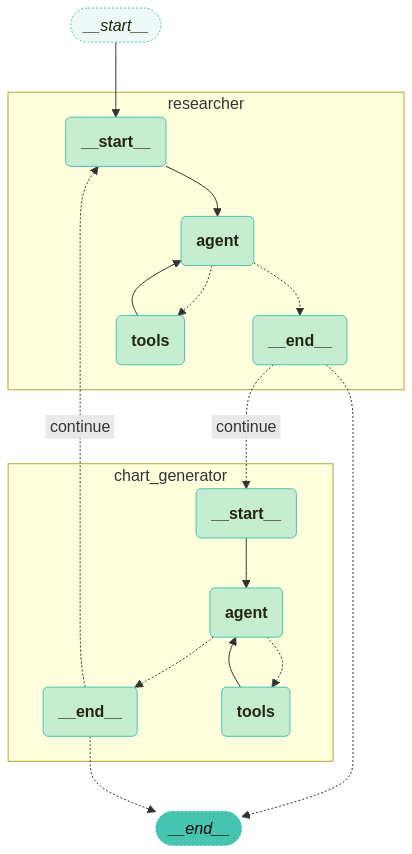

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_88CJX80NxhjQX9MOrs4GBcYc)
 Call ID: call_88CJX80NxhjQX9MOrs4GBcYc
  Args:
    query: South Korea GDP per capita from 2010 to 2024
  tavily_web_search (call_HED2t95Q93gQBKTFsloU2MBj)
 Call ID: call_HED2t95Q93gQBKTFsloU2MBj
  Args:
    query: Korea 2023 GDP per capita estimation
  tavily_web_search (call_YRbRKabc8yCU4sAUpfD4nZIj)
 Call ID: call_YRbRKabc8yCU4sAUpfD4nZIj
  Args:
    query: Korea 2024 GDP per capita forecast

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

We have gathered the data for South Korea's GDP per capita from 2010 to 2024:

1. **2010**: $23,079
2. **2011**: $25,098
3. **2012**: $25,459
4. **2013**: $27,180
5. **2014**: $29,253
6. **2015**: $28,737
7.

Python REPL can execute arbitrary code. Use with caution.
/Users/teddy/Library/Caches/pypoetry/virtualenvs/langchain-kr-CdOel15G-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/teddy/Library/Caches/pypoetry/virtualenvs/langchain-kr-CdOel15G-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/teddy/Library/Caches/pypoetry/virtualenvs/langchain-kr-CdOel15G-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/teddy/Library/Caches/pypoetry/virtualenvs/langchain-kr-CdOel15G-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserW

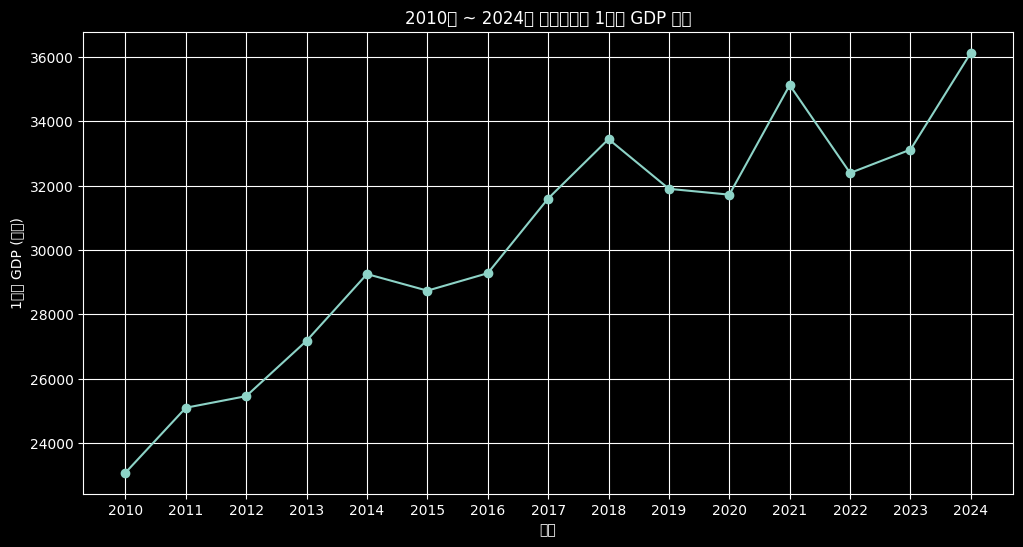


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_Zfa1cC1yceMFmp8hOWuHXpBN)
 Call ID: call_Zfa1cC1yceMFmp8hOWuHXpBN
  Args:
    code: import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 데이터
years = list(range(2010, 2025))
gdp_per_capita = [23079, 25098, 25459, 27180, 29253, 28737, 29280, 31601, 33447, 31902, 31721, 35126, 32395, 33121, 36132]

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(years, gdp_per_capita, marker='o')
plt.title('2010년 ~ 2024년 대한민국의 1인당 GDP 추이')
plt.xlabel('년도')
plt.ylabel('1인당 GDP (달러)')
plt.xticks(years)
plt.grid(True)

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fo

In [13]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])